In [1]:
import numpy as np
from task import Task
from scipy import stats
import matplotlib.pyplot as plt

In [24]:
# The policy outputs the action for each states 
def policy( state , Q_table , action_count , epsilon ):
    if np.random.random() < epsilon:
        action = np.random.choice( action_count ) 
    else: 
        action = np.argmax( Q_table[ state , : ] ) 
    return action

# Update the Q table 
def update_Q_Qlearning( Q_table , alpha , gamma , state , action , reward , new_state ):
    Q = Q_table[state, action]
    Q_prime = np.max(Q_table[new_state])
    Q_table[state, action] = Q + alpha * (reward + gamma * Q_prime - Q)
    return Q_table 

def learn_optimal(task, gamma=0.95, alpha=.3, epsilon=0.1, episodes=300):

	state_count = task.num_states
	action_count = task.num_actions

	Q_table = np.zeros((state_count, action_count))
	for episode_iter in range( episodes ):
		task.reset()
		# initial
		state = task.observe()
		action = policy( state , Q_table, action_count , epsilon )

		while True:

			new_state, reward = task.perform_action( action )
			new_action = policy( new_state , Q_table , action_count , epsilon )

			update_Q_Qlearning(Q_table , alpha , gamma , state , action , reward , new_state)
			
			if task.is_terminal( state ):
				break
			else:
				state, action = new_state, new_action

	return Q_table


def generate_samples_MDP(task, Q_b, gamma=0.95, epsilon=0.1, k=10):
	'''
		This function generates k samples using policy inherited by Q

		- Params:

		- Return:

	'''
	state_count = task.num_states
	action_count = task.num_actions
	
	transition_count_table = np.zeros( ( state_count, action_count, state_count ) )
	reward_table = np.zeros( ( state_count, action_count, state_count) )

	Ds = [] # collection of trajectories
	Rs = [] # cumulative rewards fro each trajectory
	count_sa = np.zeros((state_count, action_count))

	for episode_iter in range( k ):
		
		H = []
		R = 0

		iter_count = 0
		
		task.reset()
		# initial
		state = task.observe()
		action = policy( state , Q_b, action_count , epsilon )

		while True:

			new_state, reward = task.perform_action( action )
			
			H.append((state, action, reward))
			R += ( gamma ** iter_count * reward )
			count_sa[state, action] += 1
			
			transition_count_table[state, action, new_state] += 1
			reward_table[state, action, new_state] = reward
			
			new_action = policy( state , Q_b, action_count , epsilon )
			
			if task.is_terminal( state ):
				break
			else:
				state, action = new_state, new_action
				iter_count += 1

		Ds.append(H)
		Rs.append(R)

	return Ds, Rs, count_sa, (transition_count_table, reward_table)

def policy_eval(MDP, prob_e, gamma=.95):
	# solve by value iteration
	(transition_matrix, reward_table) = MDP
    # print MDP
	V = np.zeros((transition_matrix.shape[0]))
    # compute V table
	while 1:
		
		delta = 0.
		
		for s in range(transition_matrix.shape[0]):
			v = np.sum(prob_e[s] * np.sum(transition_matrix[s] * (reward_table[s] + gamma * V), axis = 1))
			delta = max(delta, abs(v - V[s]))
			V[s] = v

		if delta < 0.001:
			break

    # build Q_table
	Q = np.zeros((transition_matrix.shape[0], transition_matrix.shape[1]))
	
	for s in range(transition_matrix.shape[0]):
		Q[s] = np.sum(transition_matrix[s] * (reward_table[s] + gamma * V), axis = 1)

	return V, Q

def solve_MDP(MDP, gamma=.95):
	# solve by value iteration
	(transition_matrix, reward_table) = MDP
    # print MDP
	V = np.zeros((transition_matrix.shape[0]))
    # compute V table
	while 1:
		delta = 0.
		for s in range(transition_matrix.shape[0]):
			max_val = np.max(np.sum(transition_matrix[s] * (reward_table[s] + gamma * V), axis = 1))
			delta = max(delta, abs(max_val - V[s]))
			V[s] = max_val
		if delta < 0.001:
			break
    
    # build Q_table
	Q_table = np.zeros((transition_matrix.shape[0], transition_matrix.shape[1]))
	for s in range(transition_matrix.shape[0]):
		Q_table[s] = np.sum(transition_matrix[s] * (reward_table[s] + gamma * V), axis = 1)

	return V, Q_table

def count2prob(transition_count_table):

	transition_matrix = np.zeros(transition_count_table.shape)

	for s in range(transition_count_table.shape[0]):
		for a in range(transition_count_table.shape[1]):
			if np.sum(transition_count_table[s,a]) > 0:
				transition_matrix[s,a] = transition_count_table[s,a] / (np.sum(transition_count_table[s,a]) * 1.)

	return transition_matrix

def importance_sampling(H_b, prob_e):
	'''
		This function takes sample sequences from behvarioal policy,
		and compute the expected return of the evaluating policy

		- Params:

		- Return:

	'''
	Ds, Rs, count_sa = H_b

	importance_ws = np.ones(len(Ds))

	for h, D in enumerate(Ds):
		for s, a, _ in D:
			prob_b_sa = ( count_sa[s][a] * 1. ) / np.sum(count_sa[s])
			if prob_b_sa > 0:
				importance_ws[h] *= ( prob_e[s, a] / prob_b_sa )

	expected_r_e = np.dot(Rs, importance_ws) / len(Ds)

	return expected_r_e

def DR(H_b, V, Q, prob_e, gamma=0.95):

	Ds, _,  count_sa = H_b
	
	n = len(Ds)

	estimate = 0.

	for i, D in enumerate(Ds):
		p = 1.
		for t, (s, a, r) in enumerate(D):
			p_prev = p
			prob_b_sa = count_sa[s][a] / np.sum(count_sa[s])
			p *=  ( prob_e[s, a] / prob_b_sa )
			estimate += ( gamma ** t * ( r * (p / n) + (p_prev / n) * V[s] - (p / n) * Q[s, a] ) )

	return estimate

def optmial_prob_e(Q):
	prob_e = np.zeros(Q.shape)
	for s in range(Q.shape[0]):
		prob_e[s, np.argmax(Q[s])] = 1.
	return prob_e

In [84]:
tsk = Task('gridworld', 0.2).getTask()
print ('learning optimal policy for behave ...')
Q_b = learn_optimal(tsk, epsilon=0.9, episodes=5000)
print ('done learning')

learning optimal policy for behave ...
done learning


In [85]:
Ds, Rs, count_sa, (transition_count_table, reward_table) = generate_samples_MDP(tsk, Q_b)
transition_matrix = count2prob(transition_count_table)
MDP = (transition_matrix, reward_table)

prob_e_random = np.full((tsk.num_states, tsk.num_actions), 1. / tsk.num_actions)
V_random, Q_random = policy_eval(MDP, prob_e_random)

V_optimal, Q_optimal = solve_MDP(MDP)
prob_e_optimal = optmial_prob_e(Q_optimal)

epsilon: 0
k: 5
k: 55
k: 105
k: 155
k: 205
k: 255
k: 305
k: 355
k: 405
k: 455
epsilon: 0.25
k: 5
k: 55
k: 105
k: 155
k: 205
k: 255
k: 305
k: 355
k: 405
k: 455
epsilon: 0.7
k: 5
k: 55
k: 105
k: 155
k: 205
k: 255
k: 305
k: 355
k: 405
k: 455
epsilon: 1
k: 5
k: 55
k: 105
k: 155
k: 205
k: 255
k: 305
k: 355
k: 405
k: 455


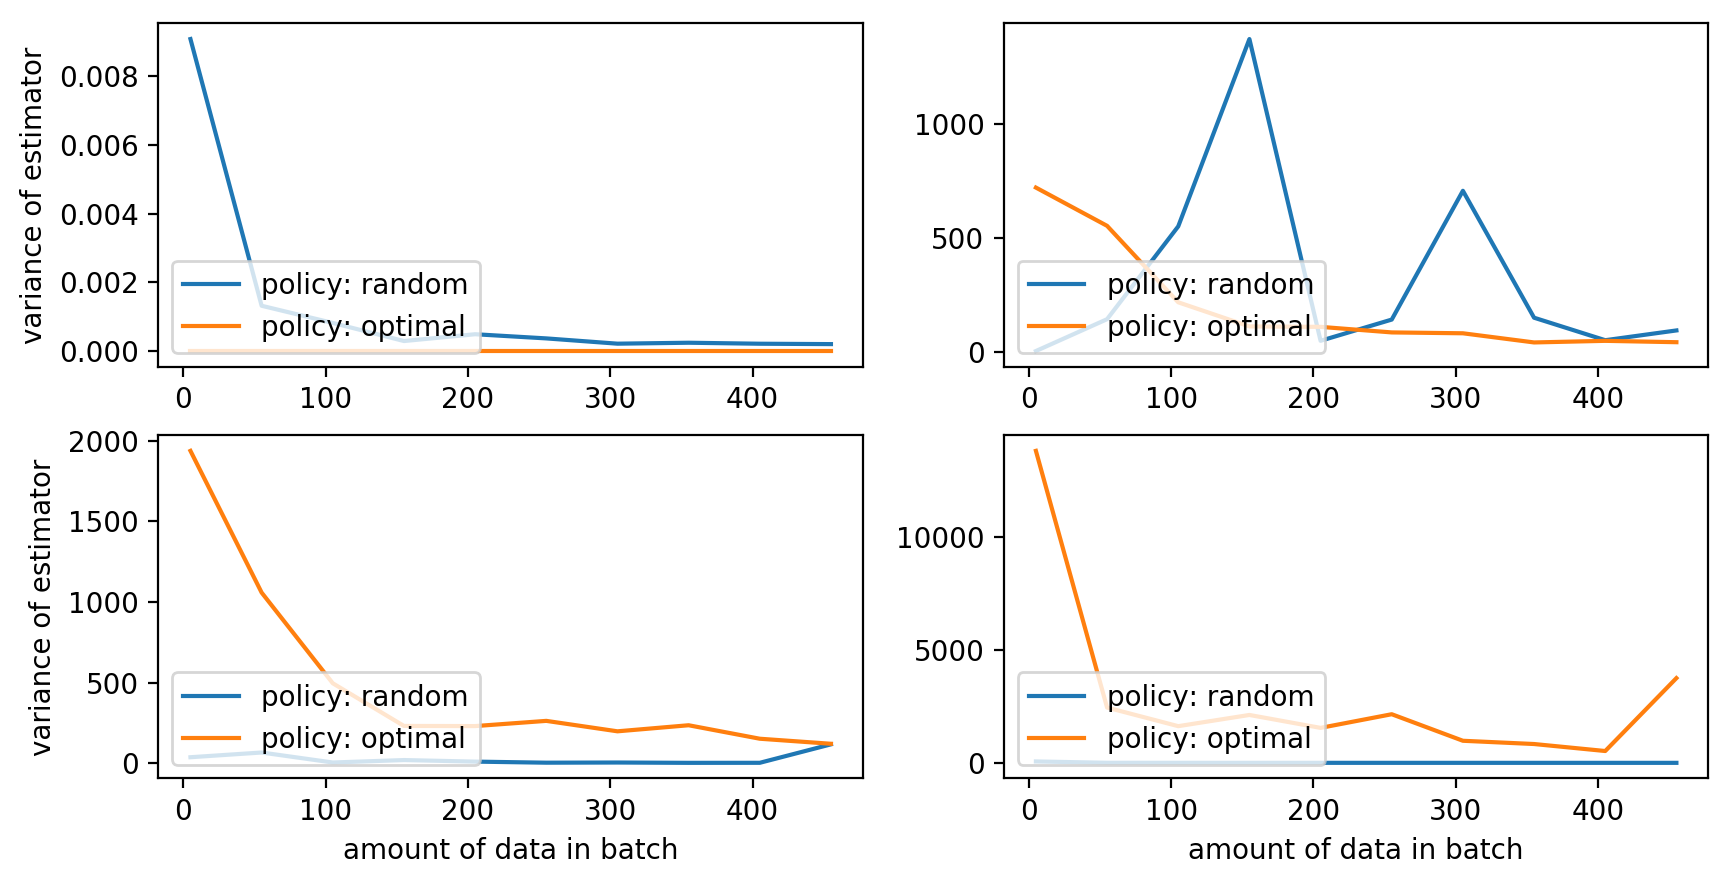

In [82]:
epsilon = [0,0.25,0.7,1]
plt.figure(figsize=(10,5), dpi = 200)

for i, e in enumerate(epsilon):
    
    print ('epsilon:', e)
    
    plt.subplot(2,2,(i+1))
    
    if i == 0:
        plt.ylabel('variance of estimator')
    if i == 2:
        plt.xlabel('amount of data in batch')
        plt.ylabel('variance of estimator')  
    if i == 3:
        plt.xlabel('amount of data in batch')
    
    random_var, optimal_var = [], []
    
    for k in range(5, 500, 50):
        
        print ('k:', k )
        
        random_samples = []
        optimal_samples = []
        
        for _ in range(20):
            Ds, Rs, count_sa, (transition_count_table, reward_table) = generate_samples_MDP(tsk, Q_b, epsilon=e, k=k)
            random_samples += [importance_sampling((Ds, Rs, count_sa), prob_e_random)]
            optimal_samples += [importance_sampling((Ds, Rs, count_sa), prob_e_optimal)]

        random_var += [np.var(random_samples)]
        optimal_var += [np.var(optimal_samples)]
        
    plt.plot(range(5, 500, 50), random_var, label='policy: random')
    plt.plot(range(5, 500, 50), optimal_var, label='policy: optimal')
    plt.legend(loc='lower left', fancybox=True, prop={'size': 10})
    
plt.show()

epsilon: 0
k: 5
k: 55
k: 105
k: 155
k: 205
k: 255
k: 305
k: 355
k: 405
k: 455
epsilon: 0.25
k: 5
k: 55
k: 105
k: 155
k: 205
k: 255
k: 305
k: 355
k: 405
k: 455
epsilon: 0.7
k: 5
k: 55
k: 105
k: 155
k: 205
k: 255
k: 305
k: 355
k: 405
k: 455
epsilon: 1
k: 5
k: 55
k: 105
k: 155
k: 205
k: 255
k: 305
k: 355
k: 405
k: 455


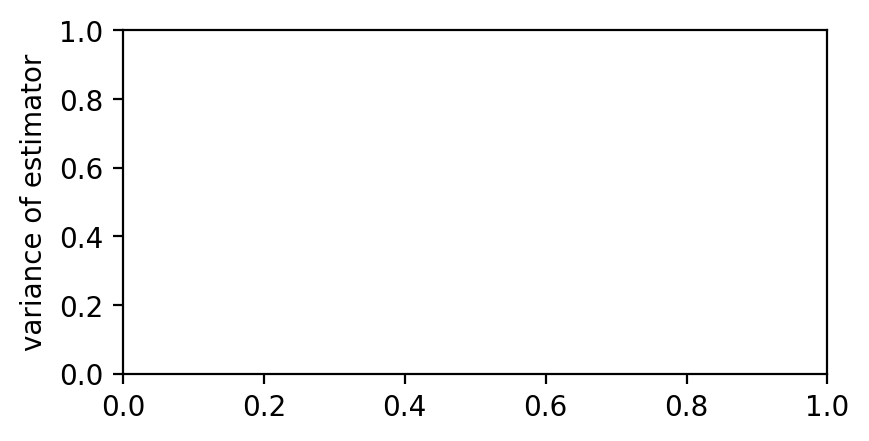

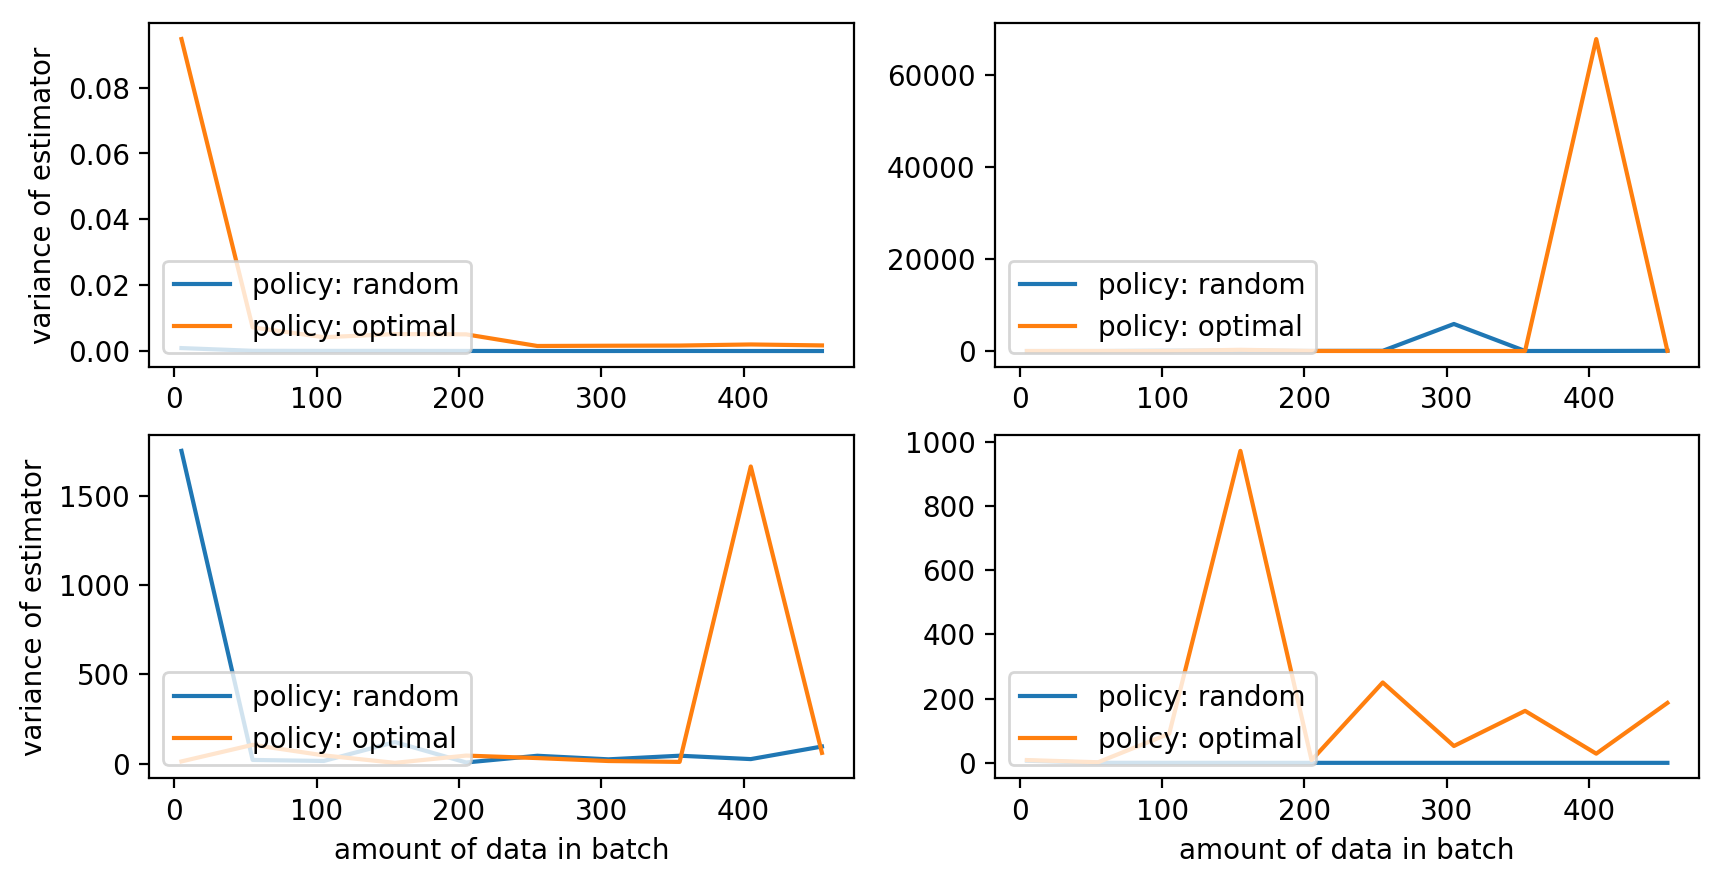

In [87]:
plt.figure(figsize=(10,5), dpi = 200)
for i, e in enumerate(epsilon):
    
    print ('epsilon:', e)
    
    plt.subplot(2,2, (i+1))
    if i == 0:
        plt.ylabel('variance of estimator')
    if i == 2:
        plt.xlabel('amount of data in batch')
        plt.ylabel('variance of estimator')  
    if i == 3:
        plt.xlabel('amount of data in batch')
    
    random_var, optimal_var = [], []
    
    for k in range(5, 500, 50):
        print ('k:', k )
        random_samples = []
        optimal_samples = []
        for _ in range(20):
            Ds, Rs, count_sa, (transition_count_table, reward_table) = generate_samples_MDP(tsk, Q_b, epsilon=e, k=k)
            random_samples += [DR((Ds, Rs, count_sa), V_random, Q_random, prob_e_random)]
            optimal_samples += [DR((Ds, Rs, count_sa), V_optimal, Q_optimal, prob_e_optimal)]

        random_var += [np.var(random_samples)]
        optimal_var += [np.var(optimal_samples)]
        
    plt.plot(range(5, 500, 50), random_var, label='policy: random')
    plt.plot(range(5, 500, 50), optimal_var, label='policy: optimal')
    plt.legend(loc='lower left', fancybox=True, prop={'size': 10})

plt.show()